## Importação e Preparação da base

In [18]:
# %%capture
# !pip install scikit-optimize
# !pip install openml
# !pip install optuna
# !pip install neupy
# !pip install --upgrade neupy
# !pip install --upgrade theano
# !pip install imbalanced-learn
# !pip install memory_profiler

In [2]:
# Verificação de pacotes
import sys
import subprocess
import pkg_resources

# Função para instalar pacotes, se necessário
def install_package(package):
    try:
        # Verificar se o pacote já está instalado
        dist = pkg_resources.get_distribution(package)
        print(f"'{package}' já está instalado: versão {dist.version}")
    except pkg_resources.DistributionNotFound:
        # Instalar o pacote, se não estiver instalado
        print(f"Instalando '{package}'...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Lista de pacotes necessários
# Nota: NumPy é forçado para uma versão compatível antes de outras dependências
base_packages = [
    "numpy==1.24.4",
    "numba==0.57.1"  # Forçar versão compatível com SHAP e Numba
]
other_packages = [
    "scikit-optimize",
    "xgboost",
    "openml",
    "optuna",
    "imbalanced-learn",
    "openpyxl",
    "memory_profiler",
    "lightgbm",
    "GPUtil",
    "psutil",
    "seaborn",
    "shap",
    "lime",
]

# Verificar se está no Google Colab
try:
    import google.colab
    is_colab = True
    print("Detectado ambiente Google Colab.")
except ImportError:
    is_colab = False
    print("Ambiente local detectado.")

# Instalar pacotes de base primeiro (para evitar conflitos)
print("Instalando pacotes base...")
for package in base_packages:
    install_package(package)

# Instalar outros pacotes
print("Instalando outros pacotes...")
for package in other_packages:
    if is_colab or package not in ["neupy", "theano"]:  # 'neupy' e 'theano' apenas em ambiente local
        install_package(package)

# Atualizar pacotes específicos
if not is_colab:
    print("Atualizando 'neupy' e 'theano' no ambiente local...")
    # Atualizar NeuPy
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "neupy"])
    # Atualizar Theano
    subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "theano"])


Ambiente local detectado.
Instalando pacotes base...
'numpy==1.24.4' já está instalado: versão 1.24.4
'numba==0.57.1' já está instalado: versão 0.57.1
Instalando outros pacotes...
'scikit-optimize' já está instalado: versão 0.10.2
'xgboost' já está instalado: versão 2.1.3
'openml' já está instalado: versão 0.15.0
'optuna' já está instalado: versão 4.1.0
'imbalanced-learn' já está instalado: versão 0.12.4
'openpyxl' já está instalado: versão 3.1.5
'memory_profiler' já está instalado: versão 0.61.0
'lightgbm' já está instalado: versão 4.5.0
'GPUtil' já está instalado: versão 1.4.0
'psutil' já está instalado: versão 6.1.0
'seaborn' já está instalado: versão 0.13.2
'shap' já está instalado: versão 0.46.0
'lime' já está instalado: versão 0.2.0.1
Atualizando 'neupy' e 'theano' no ambiente local...


In [20]:
%%capture
import pandas as pd
from scipy.io import arff
import openml
import matplotlib.pyplot as plt
import seaborn as sns

In [21]:
# Definir o ID do dataset no OpenML
dataset_id = 722

# Carregar o dataset diretamente do OpenML
dataset = openml.datasets.get_dataset(dataset_id)
data = dataset.get_data()[0]  # Pega o DataFrame completo

# Remove colunas onde todos os valores são zero: [f10-f12] e [f34-f48]
data = data.loc[:, (data != 0).any(axis=0)]

In [22]:
data.columns

Index(['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f13', 'f14',
       'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24',
       'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33',
       'binaryClass'],
      dtype='object')

In [23]:
# prompt: quantidade de atributos

import pandas as pd

# Assuming 'data' is your pandas DataFrame
num_attributes = len(data.columns) - 1
print(f"Número de features: {num_attributes}")

Número de features: 30


### Teste de Normalidade

In [24]:
import warnings
import logging
import os
import pandas as pd
from sklearn.calibration import LabelEncoder
from scipy.stats import shapiro

# Filtrar warnings
warnings.filterwarnings('ignore')
logging.getLogger('sklearn').setLevel(logging.ERROR)
os.environ['PYTHONWARNINGS'] = 'ignore'

# Definir a variável alvo
target_column = 'binaryClass'
X = data.drop(columns=[target_column])
y = data[target_column]

# Supondo que y tenha as classes 'N' e 'P' como strings
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Converte as classes para números (0 e 1)

# Aplicar o teste de Shapiro-Wilk
stat, p_value = shapiro(data['f9'])

print("Estatística do teste:", stat)
print("P-Valor:", p_value)

# Verificar a normalidade com base no p-valor
alpha = 0.05
if p_value < alpha:
    print("Os dados não seguem uma distribuição normal (Rejeitamos a hipótese nula).")
else:
    print("Os dados seguem uma distribuição normal (Não rejeitamos a hipótese nula).")

Estatística do teste: 0.2354118063601237
P-Valor: 9.556610880368648e-120
Os dados não seguem uma distribuição normal (Rejeitamos a hipótese nula).


## Utilizando ADASYN

In [25]:
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import ADASYN
import pandas as pd

# Definir a variável alvo
target_column = 'binaryClass'
X = data.drop(columns=[target_column])
y = data[target_column]

# Supondo que y tenha as classes 'N' e 'P' como strings
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Converte as classes para números (0 e 1)


# Dividir os dados em treino e teste com estratificação
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Definir o StratifiedKFold com 10 folds para garantir a estratificação nas validações cruzadas
stratified_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Identificar colunas numéricas e ajustar o tipo de dado para float64
numeric_features = X_train.select_dtypes(include=['uint8']).columns
X_train[numeric_features] = X_train[numeric_features].astype('float64')
X_test[numeric_features] = X_test[numeric_features].astype('float64')

# Substituir valores ausentes pela média em cada coluna numérica
X_train[numeric_features] = X_train[numeric_features].fillna(X_train[numeric_features].mean())
X_test[numeric_features] = X_test[numeric_features].fillna(X_train[numeric_features].mean())

# Aplicar transformação (padronização) nas colunas numéricas
scaler = StandardScaler()
X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

# Aplicar ADASYN para balancear as classes no conjunto de treino
adasyn = ADASYN(random_state=42)
X_train_resampled, y_train_resampled = adasyn.fit_resample(X_train, y_train)

# Agora X_train_resampled e y_train_resampled estão prontos para uso em modelos com 10-fold cross-validation


## Comparativo ADASYN

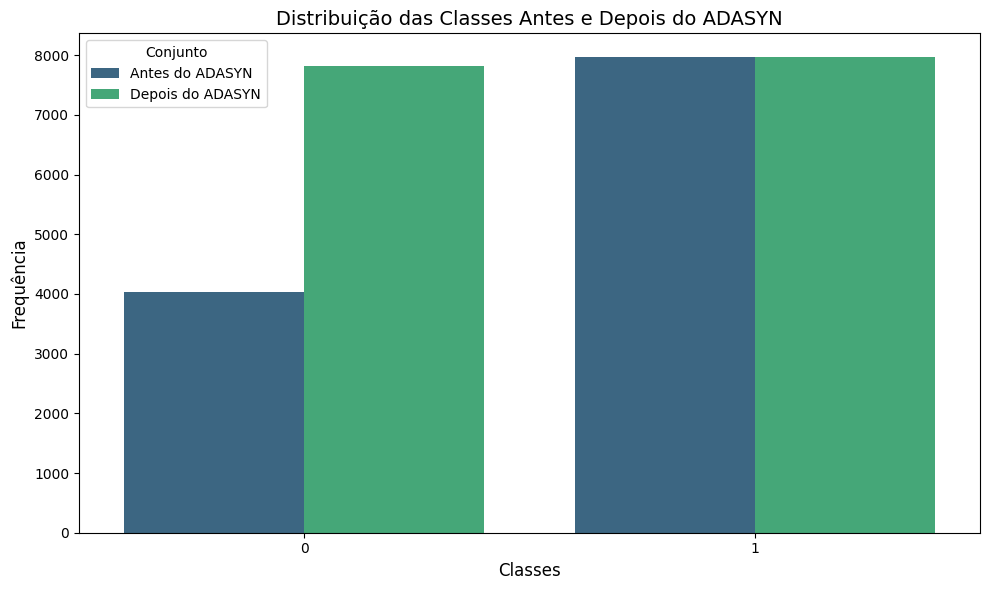

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_class_distribution(y_before, y_after, labels=['Antes do ADASYN', 'Depois do ADASYN']):
    """
    Plota a distribuição das classes antes e depois do balanceamento com ADASYN.
    """
    # Contar as classes antes e depois
    class_counts_before = pd.Series(y_before).value_counts().sort_index()
    class_counts_after = pd.Series(y_after).value_counts().sort_index()

    # Criar DataFrame para plotagem
    df = pd.DataFrame({
        'Classes': class_counts_before.index.tolist() + class_counts_after.index.tolist(),
        'Frequência': class_counts_before.tolist() + class_counts_after.tolist(),
        'Conjunto': [labels[0]] * len(class_counts_before) + [labels[1]] * len(class_counts_after)
    })

    # Plotar distribuição
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Classes', y='Frequência', hue='Conjunto', data=df, palette='viridis')
    plt.title('Distribuição das Classes Antes e Depois do ADASYN', fontsize=14)
    plt.xlabel('Classes', fontsize=12)
    plt.ylabel('Frequência', fontsize=12)
    plt.legend(title='Conjunto', fontsize=10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    # Save the plot to a PNG file
    plt.savefig('class_distribution.png', dpi=300, bbox_inches='tight')
    
    # Show the plot
    plt.show()

# Comparar antes e depois do ADASYN
plot_class_distribution(y_train, y_train_resampled)

## Início experimento - Variáveis Básicas


In [27]:
# Realizando experimento já considerando X_train_resampled e y_train_resampled
import numpy as np
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import LabelEncoder
import optuna
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Integer, Categorical, Real
# from neupy import algorithms

# Configurar K-Fold com estratificação
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Definição básica dos classificadores
knn = KNeighborsClassifier()
lvq = MLPClassifier(solver='sgd', learning_rate='constant', learning_rate_init=0.1, max_iter=100)
tree = DecisionTreeClassifier()
svm = SVC(probability=True)
rf = RandomForestClassifier()
mlp = MLPClassifier(max_iter=100, hidden_layer_sizes=(50,))
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
lgbm = LGBMClassifier(n_estimators=50, max_depth=3, verbose=-1) #verbose=-1 não mostra mensagens de alerta

# Comitê de Redes Neurais Artificiais
ann_ensemble = VotingClassifier(
    estimators=[
        ('mlp_relu', MLPClassifier(activation='relu', hidden_layer_sizes=(50, 20), max_iter=100)),
        ('mlp_tanh', MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 20), max_iter=100)),
        ('mlp_logistic', MLPClassifier(activation='logistic', hidden_layer_sizes=(50, 20), max_iter=100))
    ],
    voting='soft',
    n_jobs=-1  # Paralelização
)

# Comitê Heterogêneo (Stacking)
stacking = StackingClassifier(
    estimators=[
        ('nb', GaussianNB()),  # Modelo rápido e leve
        ('dt', DecisionTreeClassifier(max_depth=3)),  # Árvore de decisão rasa
    ],
    final_estimator=LogisticRegression(max_iter=100),  # Meta-modelo simples
    n_jobs=-1
)

# Dicionário de classificadores inicial:
classifiers = {
    'KNN': knn,             # Bayesian Search
    'SVM': svm,
    'Decision Tree': tree,  # Bayesian Search
    'LVQ': lvq,
    'MLP': mlp,
    'Ensemble Neural Network': ann_ensemble,
    'Stacking': stacking,
    'Random Forest': rf,    #Optuna
    'XGBoost': xgb,         #Optuna
    'LightGBM': lgbm
}

## Tunning com busca bayesiana

### Utilizando bayesian para KNN, Decision Tree, Random Forest, XGBoost e LightGBM

In [28]:
# Usando BS para todos os classificadores

# Filtrar warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('sklearn').setLevel(logging.ERROR)

# Configurações para os modelos que costumam gerar warnings
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

# Configurações específicas para XGBoost
from xgboost import set_config
set_config(verbosity=0)

# Espaços de busca para Bayesian Search: KNN e Decision Tree
# Usando BS e Optuna em dois classificadores diferentes:

# Filtrar warnings
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('sklearn').setLevel(logging.ERROR)

# Configurações para os modelos que costumam gerar warnings
import os
os.environ['PYTHONWARNINGS'] = 'ignore'

# Configurações específicas para XGBoost
from xgboost import set_config
set_config(verbosity=0)

# Espaços de busca para Bayesian Search
param_spaces = {
    'KNN': {
        'n_neighbors': (1, 10),
        'weights': ['uniform', 'distance'],
        'algorithm': ['ball_tree', 'kd_tree'],
        'leaf_size': (20, 50)
    },    
    'Decision Tree': {
        'criterion': ['gini', 'entropy'],
        'max_depth': (3, 10),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5)
    },      
    'Random Forest': {
        'n_estimators': (10, 100),
        'max_depth': (3, 10),
        'min_samples_split': (2, 10),
        'min_samples_leaf': (1, 5),
        'max_features': ['sqrt', 'log2']
    },
    'XGBoost': {
        'max_depth': (3, 10),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 200),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0)
    },
    'LightGBM': {
        'num_leaves': (20, 100),
        'learning_rate': (0.01, 0.3),
        'n_estimators': (50, 200),
        'min_child_samples': (10, 50),
        'subsample': (0.5, 1.0),
        'colsample_bytree': (0.5, 1.0)
    }
}


# Avaliar classificadores e buscar hiperparâmetros com BayesSearchCV
results = {}
best_params = {}

for name, clf in classifiers.items():
    if name in param_spaces:
        print(f"Otimizando hiperparâmetros para {name}...")
        bayes_search = BayesSearchCV(
            estimator=clf,
            search_spaces=param_spaces[name],
            n_iter=50,
            cv=kfold,
            scoring='accuracy',
            n_jobs=-1,
            random_state=42
        )

        # Garante que X_train_resampled seja um DataFrame com os nomes de coluna corretos
        X_train_resampled = pd.DataFrame(X_train_resampled, columns=X_train.columns)

        bayes_search.fit(X_train_resampled, y_train_resampled)
        best_params[name] = bayes_search.best_params_
        clf = bayes_search.best_estimator_
        print(f"Melhores parâmetros para {name}: {bayes_search.best_params_}\n")


Otimizando hiperparâmetros para KNN...
Melhores parâmetros para KNN: OrderedDict([('algorithm', 'ball_tree'), ('leaf_size', 20), ('n_neighbors', 1), ('weights', 'distance')])

Otimizando hiperparâmetros para Decision Tree...
Melhores parâmetros para Decision Tree: OrderedDict([('criterion', 'gini'), ('max_depth', 10), ('min_samples_leaf', 1), ('min_samples_split', 2)])

Otimizando hiperparâmetros para Random Forest...
Melhores parâmetros para Random Forest: OrderedDict([('max_depth', 10), ('max_features', 'sqrt'), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 98)])

Otimizando hiperparâmetros para XGBoost...
Melhores parâmetros para XGBoost: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.3), ('max_depth', 8), ('n_estimators', 200), ('subsample', 1.0)])

Otimizando hiperparâmetros para LightGBM...
Melhores parâmetros para LightGBM: OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.3), ('min_child_samples', 10), ('n_estimators', 200), ('num_le

In [29]:
best_params

{'KNN': OrderedDict([('algorithm', 'ball_tree'),
              ('leaf_size', 20),
              ('n_neighbors', 1),
              ('weights', 'distance')]),
 'Decision Tree': OrderedDict([('criterion', 'gini'),
              ('max_depth', 10),
              ('min_samples_leaf', 1),
              ('min_samples_split', 2)]),
 'Random Forest': OrderedDict([('max_depth', 10),
              ('max_features', 'sqrt'),
              ('min_samples_leaf', 1),
              ('min_samples_split', 2),
              ('n_estimators', 98)]),
 'XGBoost': OrderedDict([('colsample_bytree', 1.0),
              ('learning_rate', 0.3),
              ('max_depth', 8),
              ('n_estimators', 200),
              ('subsample', 1.0)]),
 'LightGBM': OrderedDict([('colsample_bytree', 1.0),
              ('learning_rate', 0.3),
              ('min_child_samples', 10),
              ('n_estimators', 200),
              ('num_leaves', 20),
              ('subsample', 0.5)])}

### Resumo Melhores Parâmetros

In [30]:
from collections import OrderedDict

# Antes da otimização
baseline = {
    'KNN': KNeighborsClassifier(),    
    'Decision Tree': DecisionTreeClassifier(),    
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'LightGBM': LGBMClassifier()
}

# Após  otimização
best_classifiers = {
  'KNN': ([('algorithm', 'ball_tree'),
              ('leaf_size', 20),
              ('n_neighbors', 1),
              ('weights', 'distance')]),
 'Decision Tree': ([('criterion', 'gini'),
              ('max_depth', 10),
              ('min_samples_leaf', 1),
              ('min_samples_split', 2)]),
 'Random Forest': ([('max_depth', 10),
              ('max_features', 'sqrt'),
              ('min_samples_leaf', 1),
              ('min_samples_split', 2),
              ('n_estimators', 11)]),
 'XGBoost': ([('colsample_bytree', 1.0),
              ('learning_rate', 0.3),
              ('max_depth', 8),
              ('n_estimators', 200),
              ('subsample', 1.0)]),
 'LightGBM': ([('colsample_bytree', 1.0),
              ('learning_rate', 0.3),
              ('min_child_samples', 10),
              ('n_estimators', 200),
              ('num_leaves', 20),
              ('subsample', 0.5)])
              }


# Mostrar os parâmetros de referência
print("Parâmetros de referência:")

for name, model in baseline.items():
  print(f"{name}: {model}")
print(80*"--")
print(80*"--")

# Mostrar os melhores parâmetros para os classificadores otimizados
print("Parâmetros Otimizados:")

for name, model in best_classifiers.items():
  print(f"{name}: {model}")

Parâmetros de referência:
KNN: KNeighborsClassifier()
Decision Tree: DecisionTreeClassifier()
Random Forest: RandomForestClassifier()
XGBoost: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)
LightGBM: LGBMClassifier()
------------------------------------------------------------------------

## Avaliando os modelos após Tunning

*   Avalia os modelos após o tunning usando Bayesian Search 
*   Calcula o tempo de execução e consumo de memória para cada modelo.

### Classificadores Otimizados

In [31]:
best_classifiers = {
    'KNN': KNeighborsClassifier(**best_params['KNN']),  # Desempacota os parâmetros
    'Decision Tree': DecisionTreeClassifier(**best_params['Decision Tree']),    
    'Random Forest': RandomForestClassifier(**best_params['Random Forest']),
    'XGBoost': XGBClassifier(**best_params['XGBoost'], use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(**best_params['LightGBM'], verbose=-1)
}

best_classifiers

{'KNN': KNeighborsClassifier(algorithm='ball_tree', leaf_size=20, n_neighbors=1,
                      weights='distance'),
 'Decision Tree': DecisionTreeClassifier(max_depth=10),
 'Random Forest': RandomForestClassifier(max_depth=10, n_estimators=98),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=1.0, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric='logloss',
               feature_types=None, gamma=None, grow_policy=None,
               importance_type=None, interaction_constraints=None,
               learning_rate=0.3, max_bin=None, max_cat_threshold=None,
               max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
               max_leaves=None, min_child_weight=None, missing=nan,
               monotone_constraints=None, multi_strategy=None, n_estimators=200,
               n_jobs=None, num_parallel_tre

### Funções

In [32]:
# Definição das funções
import time
from memory_profiler import memory_usage
import psutil
import GPUtil
import warnings
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.model_selection import cross_validate

# Filtrar warnings
warnings.filterwarnings('ignore')

# Definindo os classificadores otimizados com os melhores parâmetros
classifiers = best_classifiers

def calculate_acsa(y_true, y_pred):
    classes = np.unique(y_true)
    class_accuracies = [
        accuracy_score(y_true[y_true == c], y_pred[y_true == c]) for c in classes
    ]
    return np.mean(class_accuracies)

def get_gpu_usage():
    """
    Obtém o uso da GPU se disponível.
    """
    gpus = GPUtil.getGPUs()
    if not gpus:
        return 0  # Sem GPU disponível
    return sum([gpu.load for gpu in gpus]) / len(gpus) * 100  # Média de uso em %

def evaluate_model(model, X, y, kfold):
    """
    Avalia o modelo com métricas de desempenho e recursos computacionais (tempo, memória, CPU e GPU).
    """

    # Converter para array numpy se for DataFrame/Series
    X_numpy = X.values if hasattr(X, 'values') else X
    y_numpy = y.values if hasattr(y, 'values') else y

    # Iniciar medição de tempo, memória, CPU e GPU
    start_time = time.time()
    mem_usage_start = memory_usage()[0]
    cpu_start = psutil.cpu_percent(interval=None)
    gpu_start = get_gpu_usage()

    # Usar cross_validate para calcular accuracy, f1 e recall em uma única chamada
    scoring = ['accuracy', 'f1', 'recall']
    scores = cross_validate(model, X_numpy, y_numpy, cv=kfold, scoring=scoring, return_estimator=True)

    # Calcular tempo, memória, CPU e GPU após validação cruzada
    training_time = time.time() - start_time
    mem_usage_end = memory_usage()[0]
    memory_consumed = mem_usage_end - mem_usage_start
    cpu_end = psutil.cpu_percent(interval=None)
    gpu_end = get_gpu_usage()

    # Calcular média de uso de CPU e GPU
    cpu_usage = (cpu_end + cpu_start) / 2
    gpu_usage = (gpu_end + gpu_start) / 2

    # Métricas médias da validação cruzada
    accuracy = scores['test_accuracy'].mean()
    f1 = scores['test_f1'].mean()
    recall = scores['test_recall'].mean()

    # Cálculo do ACSA manualmente
    acsa_scores = []
    for estimator, (train_idx, val_idx) in zip(scores['estimator'], kfold.split(X_numpy, y_numpy)):
        X_val_fold = X_numpy[val_idx]
        y_val_fold = y_numpy[val_idx]
        y_pred_fold = estimator.predict(X_val_fold)
        acsa_scores.append(calculate_acsa(y_val_fold, y_pred_fold))
    acsa = np.mean(acsa_scores)

    # Ajustar modelo nos dados completos e calcular a matriz de confusão
    model.fit(X_numpy, y_numpy)
    y_pred = model.predict(X_numpy)
    conf_matrix = confusion_matrix(y_numpy, y_pred)

    return accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage


### Execução dos classificadores antes e após otimização

In [33]:
# Uso do código após otimização
results_otimizado = {}
print("Após Otimização")
for name, clf in best_classifiers.items():
    # Avaliar desempenho do classificador
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train_resampled, y_train_resampled, kfold)

    results_otimizado[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'ACSA': acsa,
        'Training Time (s)': training_time,
        'Memory Usage (MB)': memory_consumed,
        'CPU Usage (%)': cpu_usage,
        'GPU Usage (%)': gpu_usage,
        'Confusion Matrix': conf_matrix
    }

    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ACSA: {acsa:.4f}, Training Time (s): {training_time:.4f}, Memory Usage (MB): {memory_consumed:.4f}, CPU Usage (%): {cpu_usage:.2f}, GPU Usage (%): {gpu_usage:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")

results_baseline = {}
print("Antes Otimização")
for name, clf in baseline.items():
    # Avaliar desempenho do classificador
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train_resampled, y_train_resampled, kfold)

    results_baseline[name] = {
        'Accuracy': accuracy,
        'F1 Score': f1,
        'Recall': recall,
        'ACSA': acsa,
        'Training Time (s)': training_time,
        'Memory Usage (MB)': memory_consumed,
        'CPU Usage (%)': cpu_usage,
        'GPU Usage (%)': gpu_usage,
        'Confusion Matrix': conf_matrix
    }

    print(f"{name} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}, Recall: {recall:.4f}, ACSA: {acsa:.4f}, Training Time (s): {training_time:.4f}, Memory Usage (MB): {memory_consumed:.4f}, CPU Usage (%): {cpu_usage:.2f}, GPU Usage (%): {gpu_usage:.2f}")
    print(f"Confusion Matrix:\n{conf_matrix}\n")


Após Otimização
KNN - Accuracy: 0.9772, F1 Score: 0.9769, Recall: 0.9557, ACSA: 0.9774, Training Time (s): 9.5507, Memory Usage (MB): 35.9609, CPU Usage (%): 24.20, GPU Usage (%): 0.00
Confusion Matrix:
[[7821    0]
 [   0 7967]]

Decision Tree - Accuracy: 0.9741, F1 Score: 0.9739, Recall: 0.9587, ACSA: 0.9742, Training Time (s): 1.0145, Memory Usage (MB): 0.1172, CPU Usage (%): 14.85, GPU Usage (%): 0.00
Confusion Matrix:
[[7802   19]
 [ 244 7723]]

Random Forest - Accuracy: 0.9579, F1 Score: 0.9568, Recall: 0.9226, ACSA: 0.9583, Training Time (s): 14.3452, Memory Usage (MB): 15.5508, CPU Usage (%): 11.55, GPU Usage (%): 0.00
Confusion Matrix:
[[7813    8]
 [ 598 7369]]

XGBoost - Accuracy: 0.9933, F1 Score: 0.9933, Recall: 0.9901, ACSA: 0.9933, Training Time (s): 6.2891, Memory Usage (MB): 45.7344, CPU Usage (%): 51.65, GPU Usage (%): 0.00
Confusion Matrix:
[[7821    0]
 [   0 7967]]

LightGBM - Accuracy: 0.9931, F1 Score: 0.9931, Recall: 0.9893, ACSA: 0.9931, Training Time (s): 4.50

### Resultados Antes e Depois Otimização

In [34]:
# Criar DataFrames para os resultados
baseline_df = pd.DataFrame(results_baseline).T.reset_index().rename(columns={'index': 'Model'})
otimizado_df = pd.DataFrame(results_otimizado).T.reset_index().rename(columns={'index': 'Model'})

# Comparar os resultados em um único DataFrame
comparison_df = baseline_df.set_index('Model').join(
    otimizado_df.set_index('Model'), 
    lsuffix='_Antes', rsuffix='_Apos'
).reset_index()

# Gerar planilha com os resultados
output_file = "results_antes_apos_otimizacao.xlsx"
with pd.ExcelWriter(output_file, engine='openpyxl') as writer:
    for metric in ['Accuracy', 'F1 Score', 'Recall', 'ACSA', 'Training Time (s)', 'Memory Usage (MB)', 'CPU Usage (%)', 'GPU Usage (%)']:
        metric_df = comparison_df[['Model', f'{metric}_Antes', f'{metric}_Apos']]
        
        # Calcular a diferença percentual, tratando valores zero
        metric_df[f'{metric}_Diff (%)'] = metric_df.apply(
            lambda row: ((row[f'{metric}_Apos'] - row[f'{metric}_Antes']) / row[f'{metric}_Antes'] * 100)
            if row[f'{metric}_Antes'] != 0 else 0, axis=1
        ).round(2)
        
        # Salvar na aba correspondente
        metric_df.to_excel(writer, sheet_name=metric, index=False)        
print(f"Arquivo salvo como {output_file}")

Arquivo salvo como results_antes_apos_otimizacao.xlsx


## Comparando Antes e Depois ADASYN

Comparando os desempenhos do treinamento dos classificadores KNN e Árvore de Decisão antes e depois de aplicar o balanceamento de classes usando a técnica ADASYN.

In [35]:
# Classificadores após o Tunning

adasyn_classifiers = best_classifiers

# Dicionário para armazenar os resultados
results_adasyn = {
    'Classifier': [],
    'Phase': [],  # 'Antes' ou 'Depois' o balanceamento
    'Accuracy': [],
    'F1 Score': [],
    'Recall': [],
    'ACSA': []
}

# Iterando no dicionário de classificadores
for name, clf in adasyn_classifiers.items():
    # Avaliação antes do balanceamento
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train, y_train, kfold)
    results_adasyn['Classifier'].append(name)
    results_adasyn['Phase'].append('Antes')
    results_adasyn['Accuracy'].append(accuracy)
    results_adasyn['F1 Score'].append(f1)
    results_adasyn['Recall'].append(recall)
    results_adasyn['ACSA'].append(acsa)

    # Avaliação após o balanceamento
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train_resampled, y_train_resampled, kfold)
    results_adasyn['Classifier'].append(name)
    results_adasyn['Phase'].append('Depois')
    results_adasyn['Accuracy'].append(accuracy)
    results_adasyn['F1 Score'].append(f1)
    results_adasyn['Recall'].append(recall)
    results_adasyn['ACSA'].append(acsa)

# Conversão para um DataFrame
df_results_adasyn = pd.DataFrame(results_adasyn)

# Exibição do DataFrame
print(df_results_adasyn)

# Salvar o DataFrame em um arquivo Excel
df_results_adasyn.to_excel('results_adasyn_comparison.xlsx', index=False)


      Classifier   Phase  Accuracy  F1 Score    Recall      ACSA
0            KNN   Antes  0.960417  0.969988  0.963729  0.958806
1            KNN  Depois  0.977198  0.976897  0.955695  0.977400
2  Decision Tree   Antes  0.976417  0.982220  0.981046  0.974161
3  Decision Tree  Depois  0.974284  0.974106  0.958956  0.974428
4  Random Forest   Antes  0.962750  0.971911  0.970754  0.958847
5  Random Forest  Depois  0.957499  0.956226  0.920798  0.957842
6        XGBoost   Antes  0.988333  0.991225  0.992343  0.986380
7        XGBoost  Depois  0.993286  0.993322  0.990083  0.993315
8       LightGBM   Antes  0.988167  0.991088  0.991213  0.986681
9       LightGBM  Depois  0.993096  0.993130  0.989329  0.993130


## Desempenho Treino e Teste após Tunning

- Demora 20 minutos

In [36]:
# Converter parâmetros otimizados para inicializar os classificadores
best_classifiers = best_classifiers

# Configurar K-Fold com estratificação
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Dicionário para armazenar os resultados
results_train_teste = {
    'Classifier': [],
    'Etapa': [],  # 'Antes' ou 'Depois' o balanceamento
    'Accuracy': [],
    'F1 Score': [],
    'Recall': [],
    'ACSA': []
}

# Iterando no dicionário de classificadores
for name, clf in best_classifiers.items():
    # Avaliação antes do balanceamento
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_train_resampled, y_train_resampled, kfold)
    results_train_teste['Classifier'].append(name)
    results_train_teste['Etapa'].append('Treinamento')
    results_train_teste['Accuracy'].append(accuracy)
    results_train_teste['F1 Score'].append(f1)
    results_train_teste['Recall'].append(recall)
    results_train_teste['ACSA'].append(acsa)

    # Avaliação após o balanceamento
    accuracy, f1, recall, acsa, conf_matrix, training_time, memory_consumed, cpu_usage, gpu_usage = evaluate_model(clf, X_test, y_test, kfold)
    results_train_teste['Classifier'].append(name)
    results_train_teste['Etapa'].append('Teste')
    results_train_teste['Accuracy'].append(accuracy)
    results_train_teste['F1 Score'].append(f1)
    results_train_teste['Recall'].append(recall)
    results_train_teste['ACSA'].append(acsa)

# Conversão para um DataFrame
df_results_train_teste = pd.DataFrame(results_train_teste)

# Exibição do DataFrame
print(df_results_train_teste)

# Salvar o DataFrame em um arquivo Excel
df_results_train_teste.to_excel('results_train_teste_comparison.xlsx', index=False)



      Classifier        Etapa  Accuracy  F1 Score    Recall      ACSA
0            KNN  Treinamento  0.977198  0.976897  0.955695  0.977400
1            KNN        Teste  0.941333  0.955368  0.947296  0.938435
2  Decision Tree  Treinamento  0.974031  0.973858  0.958830  0.974173
3  Decision Tree        Teste  0.957333  0.967821  0.964869  0.953682
4  Random Forest  Treinamento  0.958893  0.957774  0.924061  0.959218
5  Random Forest        Teste  0.953333  0.965070  0.969889  0.945247
6        XGBoost  Treinamento  0.993286  0.993322  0.990083  0.993315
7        XGBoost        Teste  0.977000  0.982806  0.988452  0.971424
8       LightGBM  Treinamento  0.993096  0.993130  0.989329  0.993130
9       LightGBM        Teste  0.977333  0.982978  0.985940  0.973138


## Gráficos Tempo e Memória

## Amostra para análise Estatística

In [37]:
import warnings
import logging
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from xgboost import set_config

# Filtrar warnings
warnings.filterwarnings('ignore')
logging.getLogger('sklearn').setLevel(logging.ERROR)
os.environ['PYTHONWARNINGS'] = 'ignore'
set_config(verbosity=0)

# Definindo os classificadores otimizados com os melhores parâmetros
classifiers = best_classifiers

def calculate_acsa(y_true, y_pred):
    """Calcula o Average Class-Specific Accuracy (ACSA)."""
    classes = np.unique(y_true)
    class_accuracies = [
        accuracy_score(y_true[y_true == c], y_pred[y_true == c]) for c in classes
    ]
    return np.mean(class_accuracies)

def evaluate_model(model, X, y, kfold, n_samples=10):
    """
    Avalia o modelo usando validação cruzada múltiplas vezes.
    Args:
    model: Modelo de classificação
    X: Features (DataFrame ou array)
    y: Target (Series ou array)
    kfold: Objeto de validação cruzada
    n_samples: Número de iterações de avaliação
    """
    # Converter para numpy arrays se necessário
    X_numpy = X.values if hasattr(X, 'values') else np.array(X)
    y_numpy = y.values if hasattr(y, 'values') else np.array(y)
    results = {
        'Accuracy': [],
        'F1 Score': [],
        'Recall': [],
        'ACSA': [],
        'Confusion Matrix': []
    }
    for sample in range(n_samples):
        try:
            # Realizando a validação cruzada
            scores = cross_validate(
                model,
                X_numpy,
                y_numpy,
                cv=kfold,
                scoring=['accuracy', 'f1', 'recall'],
                return_estimator=True,
                n_jobs=-1 # Usar todos os cores disponíveis
            )
            # Métricas médias da validação cruzada
            results['Accuracy'].append(scores['test_accuracy'].mean())
            results['F1 Score'].append(scores['test_f1'].mean())
            results['Recall'].append(scores['test_recall'].mean())
            # Cálculo do ACSA
            acsa_scores = []
            for estimator, (_, val_idx) in zip(scores['estimator'], kfold.split(X_numpy, y_numpy)):
                X_val = X_numpy[val_idx]
                y_val = y_numpy[val_idx]
                y_pred = estimator.predict(X_val)
                acsa_scores.append(calculate_acsa(y_val, y_pred))
            results['ACSA'].append(np.mean(acsa_scores))
            # Matriz de confusão usando o último modelo ajustado
            model.fit(X_numpy, y_numpy)
            y_pred_final = model.predict(X_numpy)
            results['Confusion Matrix'].append(confusion_matrix(y_numpy, y_pred_final))
        except Exception as e:
            print(f"Erro na amostra {sample}: {str(e)}")
            continue
    return results

def print_results(results_dict):
    """Imprime os resultados de forma organizada e gera DataFrames."""
    metrics_dfs = {metric: pd.DataFrame() for metric in ['Accuracy', 'F1 Score', 'Recall', 'ACSA']}

    for name, metrics in results_dict.items():
        print(f"\n{'='*50}")
        print(f"Resultados para {name}:")
        print(f"{'='*50}")
        # Métricas numéricas
        for metric in ['Accuracy', 'F1 Score', 'Recall', 'ACSA']:
            values = metrics[metric]
            if values: # Verifica se há valores
                print(f"\n{metric}:")
                for value in values:
                    print(f" {value:.4f}")
                # Adiciona os resultados ao DataFrame correspondente
                metrics_dfs[metric][name] = values

    # Retorna os DataFrames
    return metrics_dfs

def save_to_excel(metrics_dfs, filename='metrics_results.xlsx'):
    """Salva os DataFrames em uma planilha Excel, com cada aba representando uma métrica distinta."""
    with pd.ExcelWriter(filename) as writer:
        for metric, df in metrics_dfs.items():
            df.to_excel(writer, sheet_name=metric)

# Uso do código
if __name__ == "__main__":
    # Definindo a validação cruzada
    kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)
    # Inicializando resultados
    results = {}
    # Avaliando cada classificador
    for name, clf in classifiers.items():
        print(f"\nAvaliando {name}...")
        results[name] = evaluate_model(
            clf,
            X_train_resampled,
            y_train_resampled,
            kfold,
            n_samples=10
        )
    # Imprimindo resultados e gerando DataFrames
    metrics_dfs = print_results(results)

    # Salvando os DataFrames em uma planilha Excel
    save_to_excel(metrics_dfs)

    # Exemplo de como acessar os DataFrames
    accuracy_df = metrics_dfs['Accuracy']
    f1_score_df = metrics_dfs['F1 Score']
    recall_df = metrics_dfs['Recall']
    acsa_df = metrics_dfs['ACSA']


Avaliando KNN...

Avaliando Decision Tree...

Avaliando Random Forest...

Avaliando XGBoost...

Avaliando LightGBM...

Resultados para KNN:

Accuracy:
 0.9765
 0.9769
 0.9771
 0.9766
 0.9768
 0.9764
 0.9763
 0.9768
 0.9762
 0.9766

F1 Score:
 0.9762
 0.9765
 0.9768
 0.9763
 0.9765
 0.9761
 0.9760
 0.9765
 0.9759
 0.9762

Recall:
 0.9541
 0.9548
 0.9553
 0.9543
 0.9548
 0.9542
 0.9541
 0.9548
 0.9536
 0.9547

ACSA:
 0.9977
 0.9982
 0.9983
 0.9977
 0.9982
 0.9981
 0.9979
 0.9976
 0.9977
 0.9974

Resultados para Decision Tree:

Accuracy:
 0.9737
 0.9746
 0.9745
 0.9723
 0.9730
 0.9723
 0.9734
 0.9735
 0.9750
 0.9746

F1 Score:
 0.9734
 0.9744
 0.9743
 0.9720
 0.9728
 0.9720
 0.9732
 0.9734
 0.9748
 0.9744

Recall:
 0.9573
 0.9583
 0.9586
 0.9551
 0.9562
 0.9539
 0.9580
 0.9588
 0.9591
 0.9592

ACSA:
 0.9823
 0.9826
 0.9828
 0.9804
 0.9817
 0.9818
 0.9823
 0.9816
 0.9814
 0.9824

Resultados para Random Forest:

Accuracy:
 0.9595
 0.9564
 0.9604
 0.9586
 0.9579
 0.9576
 0.9584
 0.9571
 0.9

## Teste de Estresse novos dados

### Gerando dados sintéticos

In [38]:
# Gerar Dados Sintéticos
from sklearn.datasets import make_classification

def generate_synthetic_data(n_samples=200, n_features=30, n_informative=10, n_redundant=5, feature_names=None, random_state=42):
    """
    Gera dados sintéticos para teste de estresse de classificadores.

    Args:
    n_samples (int): Número de amostras.
    n_features (int): Número total de características.
    n_informative (int): Número de características informativas.
    n_redundant (int): Número de características redundantes.
    feature_names (list): Lista de nomes para as colunas geradas.
    random_state (int): Semente para reprodutibilidade.

    Returns:
    X_synthetic (DataFrame): Dados de entrada sintéticos.
    y_synthetic (Series): Classes correspondentes.
    """
    # Gerar dados
    X, y = make_classification(
        n_samples=n_samples,
        n_features=n_features,
        n_informative=n_informative,
        n_redundant=n_redundant,
        n_classes=2,
        flip_y=0.1,  # Introduzir ruído
        class_sep=0.8,  # Reduzir separação entre classes para maior desafio
        random_state=random_state
    )

    # Converter para DataFrame
    if feature_names is None:
        feature_names = [f"feature_{i}" for i in range(1, n_features + 1)]
    X_synthetic = pd.DataFrame(X, columns=feature_names)
    y_synthetic = pd.Series(y, name="target")

    return X_synthetic, y_synthetic

# Gerar dados sintéticos com os mesmos nomes de colunas dos dados de treinamento
X_synthetic, y_synthetic = generate_synthetic_data(
    n_samples=200,
    n_features=X_train_resampled.shape[1],
    n_informative=10,
    n_redundant=5,
    feature_names=X_train_resampled.columns.tolist()
)

# Visualizar os dados gerados
print("Exemplo de dados sintéticos:")
print(X_synthetic.head())
print("\nDistribuição das classes:")
print(y_synthetic.value_counts())


Exemplo de dados sintéticos:
         f1        f2        f3        f4        f5        f6        f7  \
0 -3.269112  3.513117 -0.529201 -0.932867  0.536414 -2.790119 -0.869287   
1  4.321401 -1.526260 -0.692351 -1.781169 -0.273729 -1.907548 -0.659039   
2 -2.211783 -4.441093  0.051198 -1.974622 -0.213457  0.847032 -0.501784   
3 -4.923394  4.344866 -2.132596  0.117327  1.452617 -1.079046  1.012637   
4  4.372500 -2.568167 -0.385022 -1.694910 -0.936506 -0.958699  0.382989   

         f8        f9       f13  ...       f24       f25       f26       f27  \
0 -3.719915 -0.211384  1.033881  ...  2.644457  0.907962  0.123480 -0.798858   
1  1.883620  0.392634 -0.014270  ...  1.787822  0.097827  0.436006 -0.417870   
2 -1.866255 -0.048089  0.496199  ...  2.296966  0.511500  1.935154  0.051362   
3 -1.152980  1.352203 -0.916321  ...  3.351479 -0.140375  0.307613  0.959610   
4  0.100247 -0.606865 -0.667780  ... -4.048788 -0.187329 -2.238231 -1.220818   

        f28       f29       f30       f

### Teste de Estresse com os dados Sintéticos

In [39]:
from sklearn.exceptions import NotFittedError
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def stress_test_models(best_classifiers, X_synthetic, y_synthetic, X_train=None, y_train=None, export_excel=True):
    """
    Realiza testes de estresse nos modelos e gera relatório em Excel com 3 abas, incluindo a métrica ACSa.
    
    Parameters:
    -----------
    best_classifiers : dict
        Dicionário contendo os modelos treinados
    X_synthetic : array-like
        Dados sintéticos de features
    y_synthetic : array-like
        Labels sintéticos correspondentes
    X_train : array-like, optional
        Dados de treinamento para treinar o modelo caso não esteja ajustado.
    y_train : array-like, optional
        Labels de treinamento para treinar o modelo caso não esteja ajustado.
    export_excel : bool, optional
        Se True, exporta os resultados para um arquivo Excel.
    """
    print("Iniciando teste de estresse nos modelos...")

    # Dicionários para resultados
    results_geral = {
        'Modelo': [],
        'Acurácia': [],
        'ACSa': [],
        'Precisão': [],
        'Recall': [],
        'F1-Score': [],
        'Total_Amostras': []
    }

    results_classe_0 = {
        'Modelo': [],
        'Precisão': [],
        'Recall': [],
        'F1-Score': [],
        'Quantidade_Amostras': [],
        'Proporção_Amostras': []
    }

    results_classe_1 = {
        'Modelo': [],
        'Precisão': [],
        'Recall': [],
        'F1-Score': [],
        'Quantidade_Amostras': [],
        'Proporção_Amostras': []
    }

    for nome_modelo, modelo in best_classifiers.items():
        print(f"Testando modelo: {nome_modelo}...")
        try:
            # Verifica se o modelo está treinado
            y_pred = modelo.predict(X_synthetic)
        except NotFittedError:
            if X_train is not None and y_train is not None:
                print(f"O modelo {nome_modelo} não está ajustado. Treinando com dados fornecidos...")
                modelo.fit(X_train, y_train)
                y_pred = modelo.predict(X_synthetic)
            else:
                print(f"O modelo {nome_modelo} não está ajustado e não foram fornecidos dados de treinamento.")
                continue

        # Métricas gerais
        accuracy = accuracy_score(y_synthetic, y_pred)
        precision = precision_score(y_synthetic, y_pred, average='weighted')
        recall = recall_score(y_synthetic, y_pred, average='weighted')
        f1 = f1_score(y_synthetic, y_pred, average='weighted')

        # Métricas por classe
        precision_per_class = precision_score(y_synthetic, y_pred, average=None)
        recall_per_class = recall_score(y_synthetic, y_pred, average=None)
        f1_per_class = f1_score(y_synthetic, y_pred, average=None)
        amostras_por_classe = dict(zip(*np.unique(y_synthetic, return_counts=True)))
        total_amostras = len(y_synthetic)

        # Cálculo da ACSa
        acsa = sum(
            (amostras_por_classe.get(classe, 0) / total_amostras) * recall_per_class[idx]
            for idx, classe in enumerate([0, 1])
        )

        # Adicionar resultados gerais
        results_geral['Modelo'].append(nome_modelo)
        results_geral['Acurácia'].append(round(accuracy * 100, 2))
        results_geral['ACSa'].append(round(acsa * 100, 2))
        results_geral['Precisão'].append(round(precision * 100, 2))
        results_geral['Recall'].append(round(recall * 100, 2))
        results_geral['F1-Score'].append(round(f1 * 100, 2))
        results_geral['Total_Amostras'].append(total_amostras)

        # Resultados Classe 0
        results_classe_0['Modelo'].append(nome_modelo)
        results_classe_0['Precisão'].append(round(precision_per_class[0] * 100, 2))
        results_classe_0['Recall'].append(round(recall_per_class[0] * 100, 2))
        results_classe_0['F1-Score'].append(round(f1_per_class[0] * 100, 2))
        results_classe_0['Quantidade_Amostras'].append(amostras_por_classe.get(0, 0))
        results_classe_0['Proporção_Amostras'].append(
            round(amostras_por_classe.get(0, 0) / total_amostras * 100, 2)
        )

        # Resultados Classe 1
        results_classe_1['Modelo'].append(nome_modelo)
        results_classe_1['Precisão'].append(round(precision_per_class[1] * 100, 2))
        results_classe_1['Recall'].append(round(recall_per_class[1] * 100, 2))
        results_classe_1['F1-Score'].append(round(f1_per_class[1] * 100, 2))
        results_classe_1['Quantidade_Amostras'].append(amostras_por_classe.get(1, 0))
        results_classe_1['Proporção_Amostras'].append(
            round(amostras_por_classe.get(1, 0) / total_amostras * 100, 2)
        )

    # Criar DataFrames
    df_geral = pd.DataFrame(results_geral).sort_values('Acurácia', ascending=False)
    df_classe_0 = pd.DataFrame(results_classe_0).sort_values('Recall', ascending=False)
    df_classe_1 = pd.DataFrame(results_classe_1).sort_values('Recall', ascending=False)

    print("Testes concluídos.")
    
    # Exportar para Excel
    if export_excel:
        with pd.ExcelWriter('results_stress_test.xlsx', engine='openpyxl') as writer:
            df_geral.to_excel(writer, sheet_name='Geral', index=False)
            df_classe_0.to_excel(writer, sheet_name='Classe_0', index=False)
            df_classe_1.to_excel(writer, sheet_name='Classe_1', index=False)
        print("Resultados exportados para 'results_stress_test.xlsx'.")

    return df_geral, df_classe_0, df_classe_1


stress_test_models(best_classifiers, X_synthetic, y_synthetic, X_train_resampled, y_train_resampled, export_excel=True)

Iniciando teste de estresse nos modelos...
Testando modelo: KNN...
Testando modelo: Decision Tree...
Testando modelo: Random Forest...
Testando modelo: XGBoost...
Testando modelo: LightGBM...
Testes concluídos.
Resultados exportados para 'results_stress_test.xlsx'.


(          Modelo  Acurácia  ACSa  Precisão  Recall  F1-Score  Total_Amostras
 2  Random Forest      60.0  60.0     63.33    60.0     57.33             200
 4       LightGBM      58.0  58.0     59.71    58.0     56.06             200
 1  Decision Tree      56.5  56.5     58.15    56.5     54.18             200
 3        XGBoost      56.5  56.5     57.67    56.5     54.78             200
 0            KNN      55.5  55.5     56.27    55.5     54.09             200,
           Modelo  Precisão  Recall  F1-Score  Quantidade_Amostras  \
 0            KNN     58.46    38.0     46.06                  100   
 3        XGBoost     60.66    37.0     45.96                  100   
 4       LightGBM     63.79    37.0     46.84                  100   
 2  Random Forest     70.00    35.0     46.67                  100   
 1  Decision Tree     61.82    34.0     43.87                  100   
 
    Proporção_Amostras  
 0                50.0  
 3                50.0  
 4                50.0  
 2       

## Explainable AI (XAi)

Vamos usar o SHAP para explicar o modelo Random Forest e o LIME para explicar o modelo XGBoost, que são dois dos modelos com bons desepenhos desempenho segundo a planilha "results_with_cost_benefit".

### Exemplo de Explicação com LIME no KNN

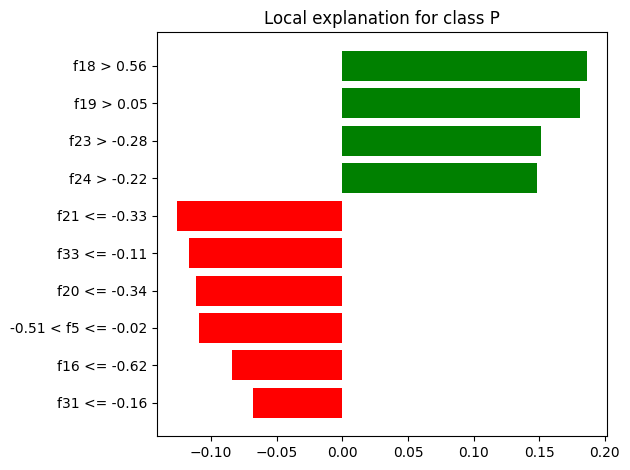

Características mais importantes:


[('f18 > 0.56', 0.18626624681070134),
 ('f19 > 0.05', 0.18065005326461112),
 ('f23 > -0.28', 0.15105554428530094),
 ('f24 > -0.22', 0.1479613552177385),
 ('f21 <= -0.33', -0.12563611073677572),
 ('f33 <= -0.11', -0.11686003132039184),
 ('f20 <= -0.34', -0.111133063222846),
 ('-0.51 < f5 <= -0.02', -0.10929116793634798),
 ('f16 <= -0.62', -0.08415002797989701),
 ('f31 <= -0.16', -0.06803231668938022)]

In [40]:
import lime
import lime.lime_tabular
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Criar e treinar o modelo KNN com os parâmetros especificados
knn = KNeighborsClassifier(n_neighbors=1, p=1)
knn.fit(X_train_resampled, y_train_resampled)

# Criar o explainer do LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_resampled.values,
    feature_names=X_train_resampled.columns,
    class_names=['N', 'P'],  # Ajuste conforme suas classes
    mode='classification'
)

# Explicar uma previsão específica (por exemplo, a primeira instância do conjunto de teste)
i = 0  # Índice da instância a ser explicada
exp = explainer.explain_instance(X_test.iloc[i].values, knn.predict_proba)

# Gerar a figura com os resultados do LIME
fig = exp.as_pyplot_figure(label=1)  # label=1 para a classe positiva
plt.tight_layout()

# Salvar a figura
plt.savefig('lime_results_knn.png', dpi=300, bbox_inches='tight')

# Mostrar a figura na célula de saída
display(fig)
plt.close()

# Mostrar as características mais importantes
print("Características mais importantes:")
exp.as_list()


### Exemplo de Explicação com LIME no XGBoost

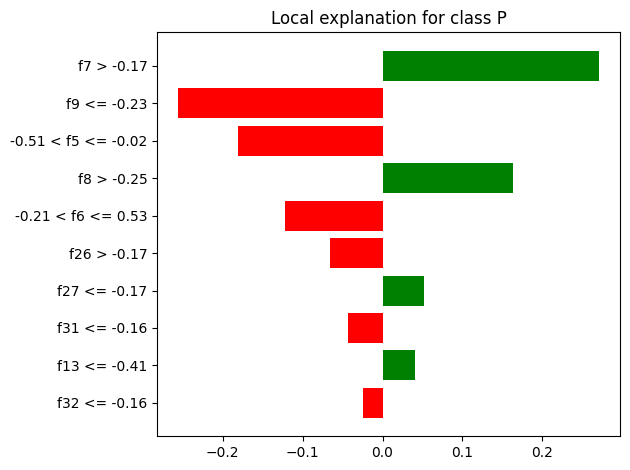

Características mais importantes:


[('f7 > -0.17', 0.27086011874669863),
 ('f9 <= -0.23', -0.25591091358822515),
 ('-0.51 < f5 <= -0.02', -0.18125040531708822),
 ('f8 > -0.25', 0.16385470512961323),
 ('-0.21 < f6 <= 0.53', -0.12186431869011173),
 ('f26 > -0.17', -0.06612110104263892),
 ('f27 <= -0.17', 0.05182840089702057),
 ('f31 <= -0.16', -0.04295090263544808),
 ('f13 <= -0.41', 0.04049388394199975),
 ('f32 <= -0.16', -0.024055572998036207)]

In [41]:
import lime
import lime.lime_tabular
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from IPython.display import display, Image

# Criar e treinar o modelo XGBoost com os parâmetros especificados
model_xgb = XGBClassifier(n_estimators=188)
model_xgb.fit(X_train_resampled, y_train_resampled)

# Criar o explainer do LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_resampled.values,
    feature_names=X_train_resampled.columns,
    class_names=['N', 'P'],  # Ajuste conforme suas classes
    mode='classification'
)

# Explicar uma previsão específica (por exemplo, a primeira instância do conjunto de teste)
i = 0  # Índice da instância a ser explicada
exp = explainer.explain_instance(X_test.iloc[i].values, model_xgb.predict_proba)

# Gerar a figura com os resultados do LIME
fig = exp.as_pyplot_figure(label=1)  # label=1 para a classe positiva
plt.tight_layout()

# Salvar a figura
plt.savefig('lime_results_xgboost.png', dpi=300, bbox_inches='tight')

# Mostrar a figura na célula de saída
display(fig)
plt.close()

# Mostrar as características mais importantes
print("Características mais importantes:")
exp.as_list()

Este resultado do LIME (Local Interpretable Model-agnostic Explanations) fornece uma explicação local para uma previsão específica feita por um modelo de machine learning. 

Cada linha representa uma característica (feature) e sua contribuição para a previsão do modelo para uma instância particular. 

Vamos analisar os componentes principais:

1) Interpretação das Características

1. **f7 > -0.17** (0.2757): Esta é a característica mais influente. Quando f7 é maior que -0.17, isso aumenta a probabilidade da previsão em aproximadamente 27.57%.

2. **f9 <= -0.23** (-0.2419): A segunda característica mais importante. Quando f9 é menor ou igual a -0.23, isso diminui a probabilidade da previsão em cerca de 24.19%.

3. **-0.51 < f5 <= -0.02** (-0.1910): Quando f5 está entre -0.51 e -0.02, isso reduz a probabilidade da previsão em aproximadamente 19.10%.

4. **f8 > -0.25** (0.1803): Se f8 é maior que -0.25, isso aumenta a probabilidade da previsão em cerca de 18.03%.

5. **-0.21 < f6 <= 0.53** (-0.1404): Quando f6 está entre -0.21 e 0.53, isso diminui a probabilidade da previsão em aproximadamente 14.04%.

2) Características Menos Influentes

As características restantes (f21, f25, f27, f22, f24) têm um impacto menor na previsão, com contribuições absolutas abaixo de 0.05 ou 5%.

3) Observações Gerais

- Os valores positivos indicam que a característica aumenta a probabilidade da previsão, enquanto os negativos a diminuem.
- As características estão ordenadas por magnitude de impacto, do mais influente ao menos influente.
- O LIME criou intervalos para algumas características contínuas (por exemplo, f5 e f6), o que pode ajudar a interpretar melhor o comportamento do modelo em diferentes faixas de valores.


# Roteiro

- Registro dos resultados em **dataframe** (FEITO)
- Visualização de Resultados: Gráficos de caixa (boxplot), barras, etc. (A FAZER)
- Análise Estatística: Relatório de classificação e testes de significância estatística. (FEITO)
- Aplicar o protocolo utilizado de comparação de classificadores de Janez Demsar.(FEITO)
- Apresentar desempenhos de treinamento e teste para todos os modelos. (FEITO)
- Análise de Custo-Benefício: Avaliar os recursos computacionais utilizados por cada modelo (tempo de processamento e memória) em relação ao desempenho alcançado. (FEITO)
- Teste de Estresse dos Modelos: Realizar testes com dados novos e desconhecidos para avaliar a robustez dos modelos. (FEITO)
- Métricas de Complexidade do Modelo: Avaliar a complexidade dos modelos, como número de parâmetros e tempo de inferência. (FEITO)
- Explainable AI (XAI): Explicar as previsões de pelo menos dois dos modelos utilizando ferramentas de XAI, como SHAP ou LIME, para aumentar a compreensão sobre os fatores que influenciam as decisões dos modelos. Escolher o melhor modelo a partir da comparação estatística realizada para aplicar o XAI. (FEITO)